**Changes:**

- Harmonize MRI + PET Features Unsupervised EMR-SLRA then Sequentially with GC Features using Regularized MKSVM

In [1]:
#get the nearest neighbor of each point
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler

# Create a large NumPy array
large_array = np.arange(10000)

# Set print options to display the entire array
np.set_printoptions(threshold=np.inf)

In [2]:
#load the mri and pet features from the LHS & RHS
data_home= "/Users/oyekanmiolatunde/Desktop/current_project/Alzheimers/process_with_clinica/Feature Based/dataset"
lhs_mri_df = pd.read_csv(f"{data_home}/LHS_MRI.csv").iloc[:,1:]
rhs_mri_df = pd.read_csv(f"{data_home}/RHS_MRI.csv").iloc[:,1:]
lhs_pet_df = pd.read_csv(f"{data_home}/LHS_PET.csv").iloc[:,1:]
rhs_pet_df = pd.read_csv(f"{data_home}/RHS_PET.csv").iloc[:,1:]

In [3]:
all_pet_df = pd.concat([lhs_pet_df,rhs_pet_df], axis=1)
all_pet_df.head()

,Left-Hippocampus,Left-Amygdala,Left-Anterior-Medial-Temporal-Lobe,Left-Anterior-Lateral-Temporal-Lobe,Left-Ambient-and-Parahippocampus-Gyri,Left-Superior-Temporal-Gyrus,Left-Inferior-Middle-Temporal-Gyri,Left-Fusiform-Gyrus,Left-Cerebellum,Left-Brainstem,...,Right-Third-Ventricle,Right-Precentral-Gyrus,Right-Rectus-Gyrus,Right-Orbito-Frontal-Gyri,Right-Inferior-Frontal-Gyrus,Right-Superior-Frontal-Gyrus,Right-Postcentral-Gyrus,Right-Superior-Parietal-Gyrus,Right-Lingual-Gyrus,Right-Cuneus
0,1.059847,0.996552,0.902433,1.021936,1.010763,1.340369,1.201393,1.047257,1.128324,0.962583,...,0.944657,1.235550,1.157825,1.323735,1.417620,1.293331,1.214842,1.255566,1.370663,1.483297
1,0.759452,0.813179,0.881662,1.101247,0.803860,1.303659,1.083634,0.947221,1.021193,0.943027,...,0.608440,1.139657,1.196488,1.349296,1.312733,1.157831,1.104809,0.916728,1.314825,1.181873
2,0.974178,0.937666,0.921953,1.060904,1.009006,1.189319,1.152129,1.023700,1.205000,0.990886,...,0.777477,1.204155,1.261954,1.260154,1.280172,1.246080,1.192184,1.230643,1.562650,1.557163
3,0.946581,0.935198,0.832810,0.994307,0.883153,1.177112,1.159773,0.989714,1.102348,0.913315,...,0.652291,1.107124,1.116573,1.227130,1.210799,1.116864,1.065101,1.113898,1.386147,1.425718
4,1.011832,1.019606,0.998256,1.139178,1.003703,1.278840,1.232091,1.127863,1.111329,0.899897,...,0.588266,1.241306,1.260825,1.375378,1.340652,1.225198,1.201179,1.232621,1.638135,1.686351


In [4]:
#load the subject info of the subjects
participants_df = pd.read_csv(f"{data_home}/participants_copy.tsv", sep="\t")
participants_df.rename(columns={"participant_id":"Subjects"}, inplace=True)

In [5]:
Adnimerge_df =  pd.read_csv(f"{data_home}/ADNIMERGE_copy.csv", low_memory=False)
Adnimerge_df.head()

,RID,COLPROT,ORIGPROT,PTID,SITE,VISCODE,EXAMDATE,DX_bl,AGE,PTGENDER,...,MidTemp_bl,ICV_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,PIB_bl,AV45_bl,FBB_bl
0,1122,ADNI1,ADNI1,003_S_1122,3,bl,1/12/07,LMCI,76.6,Female,...,15051.0,1191650.0,NaN,NaN,NaN,NaN,1.26522,NaN,NaN,NaN
1,221,ADNI1,ADNI1,005_S_0221,5,bl,3/23/06,AD,67.4,Male,...,18743.0,1775150.0,NaN,379.1,435.5,44.39,1.03931,NaN,NaN,NaN
2,221,ADNI1,ADNI1,005_S_0221,5,m24,4/3/08,AD,67.4,Male,...,18743.0,1775150.0,NaN,379.1,435.5,44.39,1.03931,NaN,NaN,NaN
3,221,ADNI1,ADNI1,005_S_0221,5,m06,9/19/06,AD,67.4,Male,...,18743.0,1775150.0,NaN,379.1,435.5,44.39,1.03931,NaN,NaN,NaN
4,221,ADNI1,ADNI1,005_S_0221,5,m12,3/14/07,AD,67.4,Male,...,18743.0,1775150.0,NaN,379.1,435.5,44.39,1.03931,NaN,NaN,NaN


In [6]:
useful_features = ["Subjects","sex","education_level","age_bl","diagnosis_sc","apoe4","mmse_bl","adas11_bl","adas13_bl","trabscor_bl",\
                  "mpaccdigit_bl","mpacctrails_bl","CDRSB","ICV","ADASQ4_bl","Ventricles_bl","ABETA_bl","TAU_bl",
                  "PTAU_bl","FDG_bl"]

participants_updated_df = participants_df.merge(Adnimerge_df,left_on=["alternative_id_1","age_bl","mmse_bl","adas13_bl","adas11_bl"],\
                             right_on=["PTID","AGE","MMSE","ADAS13","ADAS11"], how="left")
participants_updated_df = participants_updated_df[participants_updated_df.VISCODE=="bl"][useful_features]
participants_updated_df.head()

,Subjects,sex,education_level,age_bl,diagnosis_sc,apoe4,mmse_bl,adas11_bl,adas13_bl,trabscor_bl,mpaccdigit_bl,mpacctrails_bl,CDRSB,ICV,ADASQ4_bl,Ventricles_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl
0,sub-ADNI011S0003,M,18,81.3,AD,1,20,22.00,31.00,148.0,-16.29050,-15.87370,4.5,1920690.0,8.0,84599.0,741.5,239.7,22.83,1.10860
1,sub-ADNI011S0005,M,16,73.7,CN,0,29,8.67,14.67,90.0,-1.89018,-1.56702,0.0,1640770.0,4.0,34062.0,547.3,337,33.43,1.25956
2,sub-ADNI011S0010,F,12,73.9,AD,1,24,12.33,24.33,100.0,-13.69740,-12.54560,5.0,1471180.0,10.0,26820.0,357.4,329.9,31.26,1.03941
3,sub-ADNI022S0014,F,12,78.5,CN,0,29,4.33,8.33,101.0,-3.27424,-2.44011,0.0,1269540.0,4.0,46279.0,1582,203.6,16.68,1.25048
4,sub-ADNI011S0016,M,9,65.4,CN,1,28,10.33,14.33,79.0,-2.88343,-3.03600,0.0,1352000.0,4.0,17315.0,550.6,170.5,15.88,1.43716


In [7]:
participants_updated_df.isna().sum()

Subjects            0
sex                 0
education_level     0
age_bl              0
diagnosis_sc        0
apoe4               0
mmse_bl             0
adas11_bl           0
adas13_bl           3
trabscor_bl         3
mpaccdigit_bl       0
mpacctrails_bl      0
CDRSB               0
ICV                 0
ADASQ4_bl           0
Ventricles_bl       5
ABETA_bl           84
TAU_bl             84
PTAU_bl            84
FDG_bl              0
dtype: int64

In [8]:
participants_updated_df.select_dtypes(exclude="object").groupby(participants_updated_df.diagnosis_sc).mean()

,education_level,age_bl,apoe4,mmse_bl,adas11_bl,adas13_bl,trabscor_bl,mpaccdigit_bl,mpacctrails_bl,CDRSB,ICV,ADASQ4_bl,Ventricles_bl,FDG_bl
diagnosis_sc,,,,,,,,,,,,,,
AD,14.584906,75.664151,0.867925,23.150943,19.654151,30.633400,202.568627,-14.177942,-14.544119,4.698113,1.587791e+06,8.962264,53894.411765,1.033733
CN,15.533333,75.848333,0.316667,29.000000,6.893833,10.427167,88.450000,-0.565630,-0.804120,0.041667,1.542814e+06,3.033333,35584.830508,1.270001
LMCI,15.975309,74.735802,0.753086,27.283951,10.798148,18.008025,121.837500,-6.906474,-7.125831,1.444444,1.596197e+06,6.209877,40306.025316,1.179181


In [9]:
selected_features = ["Subjects","sex","diagnosis_sc","age_bl","CDRSB","mmse_bl",\
                     "apoe4","adas11_bl","mpaccdigit_bl","ICV"]
#participants_updated_df[selected_features]
participants_df_sorted=participants_updated_df[selected_features].sort_values(by="Subjects").reset_index(drop=True)
participants_df_sorted.head()

,Subjects,sex,diagnosis_sc,age_bl,CDRSB,mmse_bl,apoe4,adas11_bl,mpaccdigit_bl,ICV
0,sub-ADNI003S1122,F,LMCI,76.6,1.0,28,0,5.00,-5.394590,1191650.0
1,sub-ADNI005S0221,M,AD,67.4,7.0,20,2,24.00,-17.415900,1775150.0
2,sub-ADNI005S0223,F,CN,78.0,0.0,30,1,6.33,1.612570,1486300.0
3,sub-ADNI005S0546,M,LMCI,79.4,1.5,28,1,7.00,-5.216470,1486300.0
4,sub-ADNI005S0610,M,CN,79.0,0.0,29,0,4.00,0.319398,1557650.0


Text(0.5, 1.0, 'Distribution of participants age')

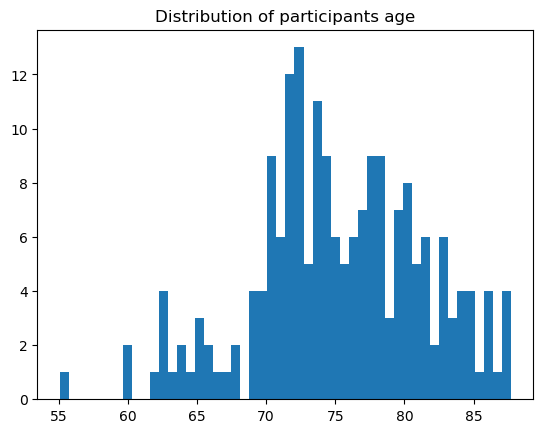

In [10]:
import matplotlib.pyplot as plt
plt.hist(participants_df_sorted.age_bl,bins=50)
plt.title("Distribution of participants age")

In [11]:
mri_features_df = pd.concat([lhs_mri_df,rhs_mri_df], axis=1)
pet_features_df =pd.concat([lhs_pet_df,rhs_pet_df], axis=1)
GC_features_df = participants_df_sorted.loc[:,"apoe4":]

In [12]:
participants_df_sorted["age_category"] = participants_df_sorted["age_bl"].apply(lambda x: "less_than_76" \
                                                                if x< 76 else "greater_than_76")
participants_df_sorted.head()

,Subjects,sex,diagnosis_sc,age_bl,CDRSB,mmse_bl,apoe4,adas11_bl,mpaccdigit_bl,ICV,age_category
0,sub-ADNI003S1122,F,LMCI,76.6,1.0,28,0,5.00,-5.394590,1191650.0,greater_than_76
1,sub-ADNI005S0221,M,AD,67.4,7.0,20,2,24.00,-17.415900,1775150.0,less_than_76
2,sub-ADNI005S0223,F,CN,78.0,0.0,30,1,6.33,1.612570,1486300.0,greater_than_76
3,sub-ADNI005S0546,M,LMCI,79.4,1.5,28,1,7.00,-5.216470,1486300.0,greater_than_76
4,sub-ADNI005S0610,M,CN,79.0,0.0,29,0,4.00,0.319398,1557650.0,greater_than_76


In [13]:
mri_features_df.shape,pet_features_df.shape,GC_features_df.shape

((194, 68), (194, 68), (194, 4))

In [14]:
LHSMRI_RHSPET_GC_Features_df = pd.concat([lhs_mri_df, rhs_pet_df, GC_features_df], axis=1)
LHSMRI_ALLPET_GC_Features_df = pd.concat([lhs_mri_df, all_pet_df, GC_features_df], axis=1)
ALLMRI_ALLPET_GC_Features_df = pd.concat([mri_features_df, pet_features_df, GC_features_df], axis=1)

In [15]:
LHSMRI_RHSPET_GC_Features_df.shape,LHSMRI_ALLPET_GC_Features_df.shape,ALLMRI_ALLPET_GC_Features_df.shape

((194, 72), (194, 106), (194, 140))

In [16]:
LHS_MRI_RHS_PET_features_df = pd.concat([lhs_mri_df,rhs_pet_df], axis=1)
LHS_MRI_ALL_PET_features_df = pd.concat([lhs_mri_df,lhs_pet_df,rhs_pet_df], axis=1)

In [17]:
LHS_MRI_RHS_PET_features_df.shape, LHS_MRI_ALL_PET_features_df.shape

((194, 68), (194, 102))

In [18]:
seed=0

In [19]:
#create a training and testing split in the ration 80:20
from sklearn.model_selection import train_test_split
train, test = train_test_split(ALLMRI_ALLPET_GC_Features_df, test_size=0.2,\
     stratify=participants_df_sorted[["diagnosis_sc","age_category","sex"]], random_state=seed)

In [20]:
X_train = train.copy()
y_train=participants_df_sorted.loc[train.index].diagnosis_sc

X_test = test.copy()
y_test=participants_df_sorted.loc[test.index].diagnosis_sc

In [21]:
train.shape, test.shape

((155, 140), (39, 140))

In [22]:
y_train.value_counts(), y_test.value_counts()

(diagnosis_sc
 LMCI    65
 CN      48
 AD      42
 Name: count, dtype: int64,
 diagnosis_sc
 LMCI    16
 CN      12
 AD      11
 Name: count, dtype: int64)

In [23]:
#Normalize Features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Determine the joint feature embeddings from MRI and PET ###

In [24]:
def compute_weight_matrix(X, n_neighbors, t):
    # X is the feature matrix for the v-th view with shape (N, M)
    # k is the number of nearest neighbors
    # t is the parameter in the Gaussian function

    N = X.shape[0]  # Number of samples
    W = np.zeros((N, N))  # Initialize the weight matrix with zeros

    # Use NearestNeighbors from sklearn to find k nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Compute the weight matrix
    for i in range(N):
        for j in indices[i]:
            if i != j :  # Exclude self-loops
                W[i, j] = np.exp(-np.linalg.norm(X[i] - X[j])**2 / t)
                W[j, i] = W[i, j]  # Ensure the matrix is symmetric

    return W

In [25]:
# mri_features = X_train_scaled[:,:lhs_mri_df.shape[1]]
# pet_features = X_train_scaled[:,lhs_mri_df.shape[1]:-4]
# GC_features =  X_train_scaled[:,-4:]
# mri_features.shape, pet_features.shape,GC_features.shape

In [26]:
def calculate_Laplacian(X, n_neighbors, t, \
                        first_mod_dim,
                        last_mod_dim
                       ):
    
    
    mri_features = X[:,:first_mod_dim]
    pet_features = X[:,first_mod_dim:]
    #GC_features =  X[:,last_mod_dim:]
    
    
    W_MRI = compute_weight_matrix(mri_features, n_neighbors, t)
    WMRI_sum = np.sum(W_MRI, axis=0)
    D1= np.diag(WMRI_sum)
    L1 = D1-W_MRI
    
    W_PET = compute_weight_matrix(pet_features, n_neighbors, t)
    WPET_sum = np.sum(W_PET, axis=0)
    D2= np.diag(WPET_sum)
    L2 = D2-W_PET
    L = np.array([L1,L2])
    
#     W_GC = compute_weight_matrix(GC_features, n_neighbors, t)
#     WGC_sum = np.sum(W_GC, axis=0)
#     D3= np.diag(WGC_sum)
#     L3 = D3-W_GC
    
#     L = np.array([L1,L2,L3])
    
    return L

In [27]:
import numpy as np
import pandas as pd

def calculate_Obj(X_hat, X, Y,U,L,V, beta, lambda1, lambda2):
    
    term1 = np.linalg.norm(X_hat - U @ Y, 'fro')**2
    term2=lambda1 * sum(beta[v]**r * np.trace(Y @ L[v] @ Y.T) for v in range(V))
    term3 = lambda2* np.linalg.norm(X_hat- X, ord=2,axis=1).sum()
    
    obj = term1+term2+term3
    
    return obj


def calculate_W_hat(X_hat, X):
    
    frobenius_norms = np.linalg.norm(X_hat - X, axis=1)
    W_hat = np.diag(1 / (2 * frobenius_norms))
    
    return W_hat

In [28]:
import scipy

In [29]:
labels = participants_df_sorted.diagnosis_sc.values

In [85]:
def EMR_SLRA(X_arr,d,lambda1,lambda2,n_neighbors,r,Iter,\
             eps,t,first_mod_dim,last_mod_dim=-4,seed=0):
    
    L = calculate_Laplacian(X_arr, n_neighbors, t,first_mod_dim,last_mod_dim)
    X = X_arr.T
    m, N = X.shape
    V = 2 #len(X)  #number of modalities
    #3print(f"X shape: {X.shape}")
    #calculate the laplacian
    
    #print(f"L:{L.shape}")
    # Initialization
    np.random.seed(seed)
    Yt = np.random.rand(d, N)
    X_hat = X + np.random.rand(m, N)
    beta = np.array([1/V]*V)
    #print(f"Initial Beta: {beta}")
    W_hat = calculate_W_hat(X_hat, X) 
    #print(f"W_hat: {W_hat.shape}")
    Objt=0
    min_obj = np.inf
    result = {}
    
    for t in range(Iter):
        # SVD decomposition
        #print(f"Iter :{t+1}")
        #print(f"\n")
        #print(f"Yt: {Yt.shape}")
        #print(f"Xhat: {X_hat.shape}")
        Zt = X_hat @ Yt.T  # m x N x N x d == > m x d
        #print(f"Zt dim: {Zt.shape}")
        
        try:
            #print(Zt.shape)
            Gt, Dt, Vt = scipy.linalg.svd(Zt,full_matrices=False)
        except:
            print(f"No convergence for SVD....Skip")
            continue
        # Update Ut+1
        #print(f"Gt: {Gt.shape}") # m x d
        #print(Gt)
        #print(f"Vt: {Vt.shape}") # d x d
        #print(f"Dt: {Dt.shape}") # d x d
        #print(Dt)
        Ut= Gt @ Vt.T #m x d
        #print(f"Ut: {Ut.shape}") 
        
        # Update Yt+1
        Lt = sum([(beta[v]**r) * L[v] for v in range(V)])
        #print(f"Lt shape: {Lt.shape}")
        Psi_t = np.eye(N) + lambda1 * Lt # N x N
        #print(f"Psi_t shape: {Psi_t.shape}")
        #Yt_next = Ut_next.T @ np.linalg.inv(Psi_t) @ X_hat
        Yt_next = Ut.T @ X_hat @ np.linalg.inv(Psi_t)  # N x N # it should be Ut.T instead of Ut_next.T
        #print(f"Yt_next:{Yt_next.shape}")
        
        # Update beta
        p_t = np.array([np.trace(Yt@ L[v] @ Yt.T) for v in range(V)]) #
        #print(f"p_t shape: {p_t.shape}")
        #beta = (r * p_t)**(1 / (1 - r)) / sum((r * p_t)**(1 / (1 - r)))

        beta = [(r * p_t[v])**(1 / (1 - r)) for v in range(V)]
        beta /= sum(beta)
        #print(f"beta shape: {beta.shape}")
        #print(f"Iter{t+1}: beta:{beta}")
        
        
        # Update X_hat and W_hat
        #X_hat_next = np.linalg.inv(np.eye(d) + lambda2 * W_hat) @ (Ut_next @ Yt_next + lambda2 * W_hat @ X)
        #print(f"W_hat: {W_hat.shape}")
        #(Ut @ Yt)==> 68 x194
        a=np.linalg.inv(np.eye(m) + lambda2 * W_hat)
        b=(Ut @ Yt) + (lambda2 *W_hat@X)#np.linalg.inv(np.eye(d) + lambda2 * W_hat) @ (U @ Y + lambda2 * W_hat @ X)#
        #print(f"a:{a.shape}")
        #print(f"b:{b.shape}")
        X_hat_next = a @ b
        #X_hat_next = (np.eye(m) + lambda2 * W_hat) @ np.linalg.pinv((Ut @ Yt) + (lambda2 *W_hat@X)).T
        #X_hat_next=X_hat_next.T
        #print(f"X_hat_next  shape: {X_hat_next.shape}")
        
        W_hat_next = calculate_W_hat(X_hat_next, X)
        
        # Calculate Objt+1 and check for convergence
        Objt_next = calculate_Obj(X_hat_next,X, Yt_next,Ut,L,V,beta, lambda1, lambda2) 
        
        if Objt_next < min_obj:
            #print("Best Minimum.....Storing results")
            result["loss"]=Objt_next
            result["Yt"]=Yt_next
            result["Ut"]=Ut
            result["iter"]=t+1
            min_obj=Objt_next
        
        #print(Objt_next)
        
        if abs(Objt_next - Objt) < eps:
            break
        
        # Update variables for the next iteration
        Yt, X_hat, W_hat, Objt = Yt_next, X_hat_next, W_hat_next, Objt_next
        #print("\n")
        #print("\n")
    
    return result

In [86]:
first_mod_dim=mri_features_df.shape[1]
last_mod_dim = -GC_features_df.shape[1]

Input_arr=X_train_scaled[:,:last_mod_dim]
d=60
lambda1=0.2
lambda2=0.1
n_neighbors=10# num neighbors
r=1.5
Iter = 500
eps=0.5
t=1


In [87]:
result=EMR_SLRA(X_arr=Input_arr,
                 d=d, 
                 lambda1=lambda1, 
                 lambda2=lambda2, 
                 n_neighbors=n_neighbors, 
                 r=r, 
                 Iter=Iter,
                 eps=eps,
                 t=t,
                 first_mod_dim=first_mod_dim,
                last_mod_dim=last_mod_dim
                
                )

In [33]:
result["Ut"].shape, result["Yt"].shape

((136, 60), (60, 155))

In [34]:
result["iter"], result["loss"]

(221, 964.8971404862872)

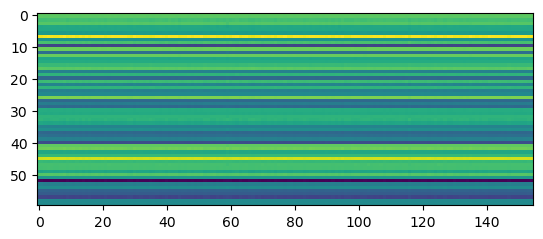

In [35]:
import matplotlib.pyplot as plt
plt.imshow(result["Yt"])

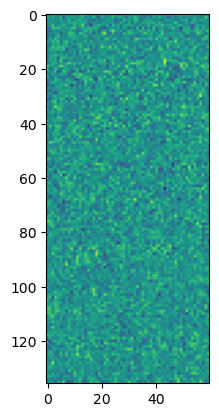

In [36]:
plt.imshow(result["Ut"])

## Test the MRI and PET Joint Embeddings on A single Kernel SVM ##

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report

In [38]:
X_train_embedding=result["Yt"].T
X_test_embedding = X_test_scaled[:,:last_mod_dim]@ result["Ut"] 

In [39]:
X_train_embedding.shape, X_test_embedding.shape

((155, 60), (39, 60))

In [40]:
svm = SVC(random_state=seed, class_weight="balanced", probability=True, C=100)
svm.fit(X_train_embedding, y_train.values)

SVC(C=100, class_weight='balanced', probability=True, random_state=0)

In [41]:
y_pred_train= svm.predict(X_train_embedding)
y_pred_test= svm.predict(X_test_embedding)

In [42]:
accuracy_score(y_train, y_pred_train)

0.4774193548387097

In [43]:
accuracy_score(y_test, y_pred_test)

0.28205128205128205

In [44]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          AD       0.28      1.00      0.44        11
          CN       0.00      0.00      0.00        12
        LMCI       0.00      0.00      0.00        16

    accuracy                           0.28        39
   macro avg       0.09      0.33      0.15        39
weighted avg       0.08      0.28      0.12        39



/Users/oyekanmiolatunde/miniconda3/envs/cvxpy_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oyekanmiolatunde/miniconda3/envs/cvxpy_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/oyekanmiolatunde/miniconda3/envs/cvxpy_env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

## Tune the Feature Embedding Params ##

In [45]:
from hyperopt import hp, fmin, tpe,Trials,STATUS_OK
param_space={
        "X_arr":Input_arr,
        "d":60,
        "lambda1":hp.loguniform("lambda1",np.log(10e-3),np.log(10e2)),
        "lambda2":hp.loguniform("lambda2",np.log(10e-3),np.log(10e2)),
        "n_neighbors":8,
        "r":hp.randint("r",5,15),
        "Iter":350,
        "eps":0.5,
        "t":1.5,
        "first_mod_dim":first_mod_dim,
        "last_mod_dim":last_mod_dim
        }

In [46]:
def tune_EMR_SLRAparams(params_space):
 
    #print(f'inside EMR_TUN:{params_space["X"].shape}')
    
    def objective(space):
        
        scores = EMR_SLRA(**space)
        
                                 
        #get the mean for all k folds acc
        loss = scores["loss"]
        
       
        return {'loss': loss,"status":STATUS_OK}

    trials_ = Trials()
    best_params= fmin(fn= objective,
                space= params_space,
                algo= tpe.suggest,
                max_evals =300,
                trials= trials_)
    
    return best_params, trials_

In [47]:
result1 = tune_EMR_SLRAparams(param_space)

100%|████████| 300/300 [06:09<00:00,  1.23s/trial, best loss: 18.78535847560839]


In [48]:
result1

({'lambda1': 0.01001733201391301, 'lambda2': 233.4190194360768, 'r': 5},
 <hyperopt.base.Trials at 0x154c201d0>)

array([<Axes: >, <Axes: >], dtype=object)

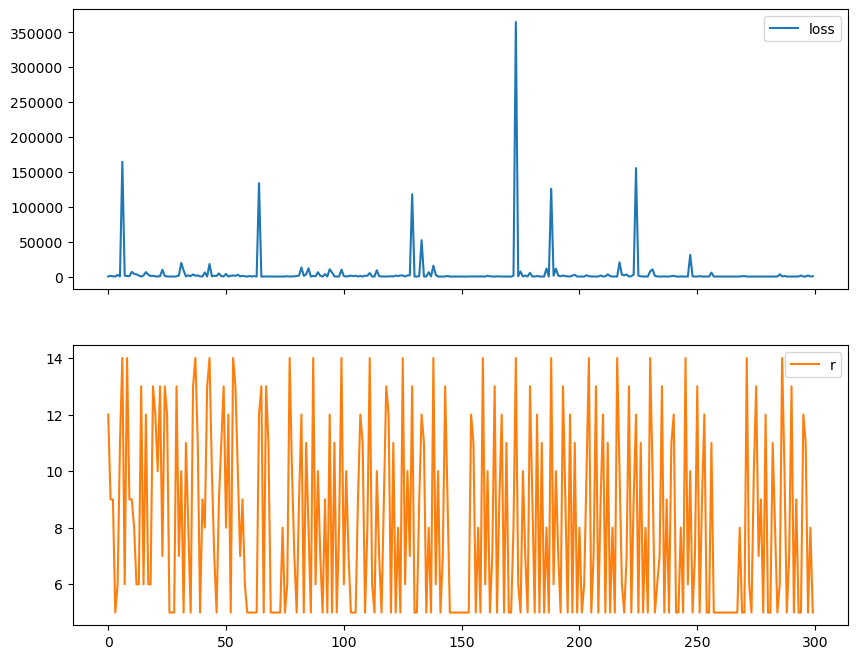

In [49]:
tpe_results=np.array([[x['result']['loss'],\
                       x['misc']['vals']['r'][0],
                          ]for x in result1[1].trials])
results_df=pd.DataFrame(tpe_results, columns=["loss","r"])
results_df.plot(subplots=True,figsize=(10, 8))

In [50]:
result1_ = result1[0]

result_best= EMR_SLRA(
                      X_arr=param_space["X_arr"],
                      d=param_space["d"],
                      lambda1=result1_["lambda1"],
                      lambda2=result1_["lambda2"],
                      n_neighbors=param_space["n_neighbors"],
                      r=result1_["r"],
                      Iter=param_space["Iter"],
                      eps=param_space["eps"],
                      t=param_space["t"],
                      first_mod_dim=first_mod_dim,
                    last_mod_dim = last_mod_dim
              
                     )

In [51]:
result_best["loss"],result1_["r"],#result1_["n_neighbors"]

(18.78535847560839, 5)

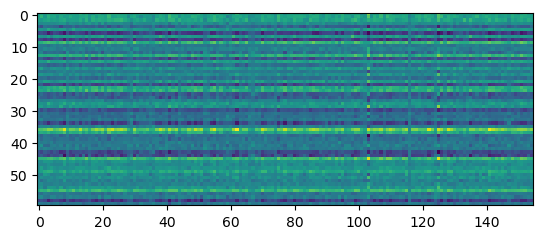

In [52]:
plt.imshow(result_best["Yt"])

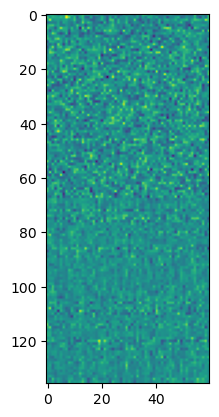

In [53]:
plt.imshow(result_best["Ut"])

In [54]:
new_X_train=result_best["Yt"].T
new_X_test = X_test_scaled[:,:last_mod_dim]@ result_best["Ut"] 

In [55]:
new_X_train.shape, new_X_test.shape

((155, 60), (39, 60))

## Training Single Kernel SVM with the Embeddings ##

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
svm = SVC(random_state=seed, class_weight="balanced", probability=True, C=10)
svm.fit(new_X_train, y_train.values)

SVC(C=10, class_weight='balanced', probability=True, random_state=0)

In [57]:
y_pred_train= svm.predict(new_X_train)
y_pred_test= svm.predict(new_X_test)

In [58]:
accuracy_score(y_train, y_pred_train)

0.7806451612903226

In [59]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

          AD       0.78      0.93      0.85        42
          CN       0.72      0.85      0.78        48
        LMCI       0.85      0.63      0.73        65

    accuracy                           0.78       155
   macro avg       0.78      0.80      0.78       155
weighted avg       0.79      0.78      0.78       155



In [60]:
accuracy_score(y_test, y_pred_test)

0.6153846153846154

In [61]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

          AD       0.53      0.82      0.64        11
          CN       0.70      0.58      0.64        12
        LMCI       0.67      0.50      0.57        16

    accuracy                           0.62        39
   macro avg       0.63      0.63      0.62        39
weighted avg       0.64      0.62      0.61        39



## Add the GC Features to the MRI and PET Embeddings ##

### Method 1: Concatenate the Embeddings with GC Features ###

In [62]:
GC_train_features = X_train_scaled[:,last_mod_dim:]
GC_test_features = X_test_scaled[:,last_mod_dim:]

MRI_PET_GC_Embedding_Train = np.concatenate((new_X_train,GC_train_features), axis=1)
MRI_PET_GC_Embedding_Test = np.concatenate((new_X_test,GC_test_features), axis=1)

In [63]:
MRI_PET_GC_Embedding_Train.shape,MRI_PET_GC_Embedding_Test.shape

((155, 64), (39, 64))

In [64]:
svm_updated = SVC(random_state=seed, class_weight="balanced", probability=True, C=10)
svm_updated.fit(MRI_PET_GC_Embedding_Train, y_train.values)

SVC(C=10, class_weight='balanced', probability=True, random_state=0)

In [65]:
y_pred_train_updated= svm_updated.predict(MRI_PET_GC_Embedding_Train)
y_pred_test_updated= svm_updated.predict(MRI_PET_GC_Embedding_Test)

In [66]:
print(classification_report(y_test, y_pred_test_updated))

              precision    recall  f1-score   support

          AD       0.77      0.91      0.83        11
          CN       0.92      0.92      0.92        12
        LMCI       0.86      0.75      0.80        16

    accuracy                           0.85        39
   macro avg       0.85      0.86      0.85        39
weighted avg       0.85      0.85      0.85        39



### Method 3: Combine the Embeddings with GC Features using MKSVM ###

In [67]:
from scipy.optimize import minimize, LinearConstraint

class SimpleMKL_Multiclass:
    def __init__(self, 
                 kernels, 
                 C,
                 tol,
                 d_min,
                 random_state=0
                ):
        self.kernels = kernels  # List of precomputed kernel matrices
        self.C = C              # Regularization parameter
        self.tol = tol
        self.d = None           # Kernel weights
        self.svm = None         # SVM model
        self.random_state=random_state
        self.d_min=d_min

    def fit(self, X, y):
        M = len(self.kernels)
        N = X.shape[0]
        
        # Initialize kernel weights
        d = np.ones(M) / M
        
        # Define objective function J(d)
        def J(d):
            # Compute combined kernel
            K_combined = sum(d[m] * self.kernels[m] for m in range(M))
            
            # Train SVM and get dual coefficients
            self.svm = SVC(C=self.C, kernel='precomputed',
                           class_weight="balanced",
                           random_state=self.random_state
                          )
            self.svm.fit(K_combined, y)
            
            #number of estimators
            self.num_estimators = len(self.svm.dual_coef_)
            
            J_list = []
            
            for i in range(self.num_estimators):
            
                dual_coef = self.svm.dual_coef_[i]
                support_vectors = self.svm.support_
                
                J_temp = -0.5 * np.dot(dual_coef, np.dot(K_combined[support_vectors][:, support_vectors], dual_coef)) + np.sum(np.abs(dual_coef))
                
                J_list.append(J_temp)
            # Compute objective value
            return np.array(J_list).sum()
        
        
        # Define gradient of J(d)
        def grad_J(d):
            
            grad = np.zeros((self.num_estimators,M))
            
            for m in range(M):
                
                K_m = self.kernels[m]
                
                for i in range(self.num_estimators):
                    
                    dual_coef = self.svm.dual_coef_[i]
                    support_vectors = self.svm.support_
                    grad[i][m] = -0.5 * np.dot(dual_coef, np.dot(K_m[support_vectors][:, support_vectors], dual_coef))
            
            #print(f"grad:{grad}")
            #print(f"grad_sum;{grad.sum(axis=0)}")
            
            return grad.sum(axis=0)

        # Optimization problem to minimize J(d) subject to constraints
        constraints = ({'type': 'eq', 'fun': lambda d: np.sum(d) - 1},  # Sum of weights must be 1
                       {'type': 'ineq', 'fun': lambda d: d})            # Weights must be non-negative
        
        
       
        bounds = [(self.d_min, 1-self.d_min)] * len(self.kernels)
        
        # Solve optimization problem
        opt_res = minimize(J, d, method='SLSQP', jac=grad_J, constraints=constraints,
                           tol=self.tol,bounds=bounds
                          )
        
        
        self.d = opt_res.x  # Store the optimal kernel weights
        
        #print(self.d)

    def predict(self, kernels):
        # Compute combined kernel using the learned weights
        K_combined = sum(self.d[m] * kernels[m] for m in range(len(kernels)))
        return self.svm.predict(K_combined)


In [68]:
from sklearn.metrics.pairwise import pairwise_kernels

class ConstructKernelMatrix:
    
    def __init__(self,
                 first_mod_feature_len, 
                 last_mod_feature_len,
                 kernel1,kernel2,
                 gamma1,gamma2,
                 coef1,coef2,
                 degree1,degree2
        ):
        
        self.first_mod_feature_len = first_mod_feature_len
        self.last_mod_feature_len = last_mod_feature_len
        
        self.kernel1 = kernel1
        self.kernel2 = kernel2
        self.gamma1=gamma1
        self.gamma2=gamma2
        self.coef1=coef1
        self.coef2=coef2
        self.degree1 = degree1
        self.degree2 = degree2

        
        
    def construct_kernel_matrix(self, X,Z,kernel, gamma, coef, degree):
        
        if kernel =="rbf":
            
            return pairwise_kernels(X,Z, metric=kernel, gamma=gamma)
        
        elif kernel =="poly":
            
            return pairwise_kernels(X,Z, metric=kernel, coef0=coef, degree=degree)
        
        else:
            return pairwise_kernels(X,Z, metric=kernel)
        
        
    def train_kernel_matrix(self, train_data):
        
        
        #slice data for modality 1
        self.data_m1_train = train_data[:,:self.first_mod_feature_len]
        
        #slice data for source/modality 2
        self.data_m2_train = train_data[:,self.first_mod_feature_len:]
        
        
        Kernel_matrix1 = self.construct_kernel_matrix(self.data_m1_train,self.data_m1_train,
                                                      self.kernel1, self.gamma1,
                                                      self.coef1, self.degree1
                                                     )
        
        
        Kernel_matrix2 = self.construct_kernel_matrix(self.data_m2_train,self.data_m2_train,
                                                      self.kernel2, self.gamma2,
                                                      self.coef2, self.degree2
                                                     )
        
        return np.array([Kernel_matrix1,Kernel_matrix2])
    
    
    
    def test_kernel_matrix(self, test_data):
        
        #slice data for modality 1
        data_m1_test = test_data[:,:self.first_mod_feature_len]
        
        #slice data for source/modality 2
        data_m2_test = test_data[:,self.first_mod_feature_len:]
        
        
        Kernel_matrix1 = self.construct_kernel_matrix(data_m1_test,self.data_m1_train,
                                                      self.kernel1, self.gamma1,
                                                      self.coef1, self.degree1
                                                     )
        
        
        Kernel_matrix2 = self.construct_kernel_matrix(data_m2_test,self.data_m2_train,
                                                      self.kernel2, self.gamma2,
                                                      self.coef2, self.degree2
                                                     )
        
        
        return np.array([Kernel_matrix1,Kernel_matrix2])

In [69]:
from sklearn.utils.multiclass import unique_labels
from sklearn.base import BaseEstimator,ClassifierMixin
class Multikernel_SVM(ConstructKernelMatrix,
                      BaseEstimator, ClassifierMixin):
    
    def __init__(self,
                 first_mod_feature_len,
                 last_mod_feature_len,
                 d_min,
                 kernel1,
                 kernel2,
                 gamma1,
                 gamma2,
                 coef1,
                 coef2,
                 degree1,
                 degree2,
                 tol=1e-3,
                 C=1.0,
                 random_state=0   
        ):
        
        self.tol=tol
        self.C=C
        self.first_mod_feature_len=first_mod_feature_len
        self.last_mod_feature_len=last_mod_feature_len
        self.kernel1=kernel1
        self.kernel2=kernel2
        self.gamma1=gamma1
        self.gamma2=gamma2
        self.coef1=coef1
        self.coef2=coef2
        self.degree1=degree1
        self.degree2=degree2
        self.tol=tol
        self.C=C
        self.random_state=random_state  
        self.model = None
        self.d = None
        self.d_min=d_min
         
        super(). __init__(
            first_mod_feature_len=first_mod_feature_len,
            last_mod_feature_len=last_mod_feature_len,
            kernel1=kernel1,
            kernel2=kernel2,
            gamma1=gamma1,
            gamma2=gamma2,
            coef1=coef1,
            coef2=coef2,
            degree1=degree1,
            degree2=degree2,

        )
        
        
    def fit(self, train_data, y_train):
        
        self.classes_ = unique_labels(y_train)
        
        
        self.Kernel_Matrix_Obj = ConstructKernelMatrix(
                                   first_mod_feature_len=self.first_mod_feature_len,
                                   last_mod_feature_len=self.last_mod_feature_len,
                                   kernel1=self.kernel1, 
                                   kernel2= self.kernel2,
                                    gamma1=self.gamma1,
                                    gamma2=self.gamma2,
                                    coef1=self.coef1,
                                    coef2=self.coef2,
                                    degree1=self.degree1,
                                    degree2=self.degree2,
                                  )
        self.train_kernel_matrices = self.Kernel_Matrix_Obj.train_kernel_matrix(train_data)
        
        
        self.model = SimpleMKL_Multiclass(kernels=self.train_kernel_matrices, 
                                        C=self.C,
                                        tol=self.tol,
                                        random_state=self.random_state,
                                        d_min=self.d_min
                                       )
        
        
        self.model.fit(self.train_kernel_matrices, y_train)
        
        self.d = self.model.d
        
        
        return self
        
        
        
    def predict(self, test_data):
        
        self.test_kernel_matrices = self.Kernel_Matrix_Obj.test_kernel_matrix(test_data)
        
        predictions = self.model.predict(self.test_kernel_matrices)
        
        return predictions

In [70]:
kernel_params = {"d_min":0.2,"kernel1":"rbf","kernel2":"rbf",
               "degree1":2,"degree2":2,
                "gamma1":0.15, "gamma2":0.3,
                "coef1":0.5, "coef2":0.5,
                 "first_mod_feature_len":new_X_train.shape[1],
                 "last_mod_feature_len":last_mod_dim,
                 "C":10.0, "tol":1e-3,"random_state":0
                 
                }


In [71]:
model = Multikernel_SVM(**kernel_params)

In [72]:
model.fit(MRI_PET_GC_Embedding_Train, y_train)

Multikernel_SVM(C=10.0, coef1=0.5, coef2=0.5, d_min=0.2, degree1=2, degree2=2,
                first_mod_feature_len=60, gamma1=0.15, gamma2=0.3,
                kernel1='rbf', kernel2='rbf', last_mod_feature_len=-4)

In [73]:
y_pred3=model.predict(MRI_PET_GC_Embedding_Test)

In [74]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

          AD       0.92      1.00      0.96        11
          CN       0.92      0.92      0.92        12
        LMCI       0.93      0.88      0.90        16

    accuracy                           0.92        39
   macro avg       0.92      0.93      0.93        39
weighted avg       0.92      0.92      0.92        39



## Tune Hyperparams ##

In [82]:
from sklearn.model_selection import cross_validate,StratifiedKFold
kfold = StratifiedKFold(n_splits=5)

In [83]:
degree_space=[2,3,4]
kernel_space=["linear","rbf","poly"]


svm_space={
            "d_min":0.2,
            "C":hp.loguniform("C",np.log(2e-3), np.log(2e3)),
            "gamma1":hp.uniform("gamma1",0, 1),
             "gamma2":hp.uniform("gamma2",0, 1),
            "kernel1":hp.choice("kernel1",kernel_space),
            "kernel2":hp.choice("kernel2",kernel_space),
            "degree1":hp.randint("degree1",2,5),
             "degree2":hp.randint("degree2",2,5),
            "coef1":hp.uniform("coef1",0,10),
            "coef2":hp.uniform("coef2",0,10),
             "first_mod_feature_len":new_X_train.shape[1],
             "last_mod_feature_len":last_mod_dim,
             "tol":1e-3,"random_state":0
        } 

def tune_MKSVM(X_train, y_train, param_space):
    

    def objective(space):

        model = Multikernel_SVM(**space)

        scores = cross_validate(model,X_train, y_train, cv=kfold, \
                                scoring=("accuracy"),return_train_score=True\
                                    ,return_estimator=True, n_jobs=-1)

        #get the mean for all k folds acc
        accuracy = scores["test_score"].mean()
        # We aim to maximize accuracy, therefore we return it as a negative value
        return {'loss': -accuracy,"status":STATUS_OK}

    trials = Trials()
    
    best_params = fmin(fn= objective,
                space= param_space,
                algo= tpe.suggest,
                max_evals = 750,
                trials= trials)
    
    return best_params, trials

In [84]:
best_params, trials = tune_MKSVM( MRI_PET_GC_Embedding_Train, 
                                           y_train,svm_space
                                          )

 75%|████▌ | 565/750 [00:18<00:05, 33.83trial/s, best loss: -0.8387096774193548]

/Users/oyekanmiolatunde/miniconda3/envs/cvxpy_env/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/Users/oyekanmiolatunde/miniconda3/envs/cvxpy_env/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


100%|██████| 750/750 [00:24<00:00, 31.06trial/s, best loss: -0.8387096774193548]


In [85]:
best_params

{'C': 1.0307700114468668,
 'coef1': 7.986292093362605,
 'coef2': 9.971963822041,
 'degree1': 2,
 'degree2': 2,
 'gamma1': 0.4973699925057741,
 'gamma2': 0.08928523721166726,
 'kernel1': 2,
 'kernel2': 2}

In [86]:
best_params_ = best_params.copy()
best_params_["kernel1"] = kernel_space[best_params["kernel1"]]
best_params_["kernel2"] = kernel_space[best_params["kernel2"]]
best_params_["d_min"] = svm_space["d_min"]
best_params_

{'C': 1.0307700114468668,
 'coef1': 7.986292093362605,
 'coef2': 9.971963822041,
 'degree1': 2,
 'degree2': 2,
 'gamma1': 0.4973699925057741,
 'gamma2': 0.08928523721166726,
 'kernel1': 'poly',
 'kernel2': 'poly',
 'd_min': 0.2}

In [87]:
MKSVM_best = Multikernel_SVM(**kernel_params)
MKSVM_best.fit(MRI_PET_GC_Embedding_Train, y_train.values)

Multikernel_SVM(C=10.0, coef1=0.5, coef2=0.5, d_min=0.2, degree1=2, degree2=2,
                first_mod_feature_len=60, gamma1=0.15, gamma2=0.3,
                kernel1='rbf', kernel2='rbf', last_mod_feature_len=-4)

In [88]:
y_pred_train_best= MKSVM_best.predict(MRI_PET_GC_Embedding_Train)
y_pred_test_best= MKSVM_best.predict(MRI_PET_GC_Embedding_Test)

In [89]:
accuracy_score(y_train, y_pred_train_best)

0.9290322580645162

In [90]:
accuracy_score(y_test, y_pred_test_best)

0.9230769230769231

In [91]:
print(classification_report(y_test, y_pred_test_best))

              precision    recall  f1-score   support

          AD       0.92      1.00      0.96        11
          CN       0.92      0.92      0.92        12
        LMCI       0.93      0.88      0.90        16

    accuracy                           0.92        39
   macro avg       0.92      0.93      0.93        39
weighted avg       0.92      0.92      0.92        39



In [92]:

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,balanced_accuracy_score,confusion_matrix

model_measures={"train":{"Precision":[],
                   "Recall":[],
                   "F1_Score":[],
                   "Accuracy":[]},
                
              "test":{"Precision":[],
                   "Recall":[],
                   "F1_Score":[],
                   "Accuracy":[]}
               }


def calculate_metrics(true_labels, predicted_labels):
    """
    Calculate precision, recall, F1 score, and accuracy scores for a multiclass classification model.
    
    Parameters:
        true_labels (array-like): True labels.
        predicted_labels (array-like): Predicted labels.
        
    Returns:
        dict: A dictionary containing precision, recall, F1 score, and accuracy scores.
    """
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'Accuracy': accuracy
    }
    
    return metrics

In [93]:
random_seed_list = [20, 35, 86, 89, 95, 66,  1, 89, 5, 0]

In [94]:
# Train and evaluate the algorithms
from itertools import combinations

def perform_experiment_replication(features_df, 
                                   participants_df,
                                   d_min,
                                   embedding_dim,
                                   first_mod_dim, 
                                   last_mod_dim,
                                   number_of_run=10
                                  ):

    model_acc_dict={"train":{"Precision":[],
                   "Recall":[],
                   "F1_Score":[],
                   "Accuracy":[]},
                
              "test":{"Precision":[],
                   "Recall":[],
                   "F1_Score":[],
                   "Accuracy":[]}
               }


    kernel_space=["linear","rbf","poly"]
    svm_space={
            "d_min":d_min,
            "C":hp.loguniform("C",np.log(2e-3), np.log(2e3)),
            "gamma1":hp.uniform("gamma1",0, 1),
             "gamma2":hp.uniform("gamma2",0, 1),
            "kernel1":hp.choice("kernel1",kernel_space),
            "kernel2":hp.choice("kernel2",kernel_space),
            "degree1":hp.randint("degree1",2,5),
             "degree2":hp.randint("degree2",2,5),
            "coef1":hp.uniform("coef1",0,10),
            "coef2":hp.uniform("coef2",0,10),
             "first_mod_feature_len":embedding_dim,
             "last_mod_feature_len":last_mod_dim,
             "tol":1e-3,"random_state":0
            } 
    
    SLRA_space={
        #"X_arr":Input_arr,
        "d":embedding_dim, #60
        "lambda1":hp.loguniform("lambda1",np.log(10e-3),np.log(10e2)),
        "lambda2":hp.loguniform("lambda2",np.log(10e-3),np.log(10e2)),
        "n_neighbors":8,
        "r":hp.randint("r",5,15),
        "Iter":350,
        "eps":0.5,
        "t":1.5,
        "first_mod_dim":first_mod_dim,
        "last_mod_dim":last_mod_dim
        }
    

    model_accs={}

    for run in range(number_of_run):

        # Split the data into training and testing sets
        train, test = train_test_split(features_df, test_size=0.2, \
                                       stratify=participants_df[["diagnosis_sc","age_category","sex"]],\
                                           random_state=random_seed_list[run])
        
        X_train = train.copy()
        y_train=participants_df_sorted.loc[train.index].diagnosis_sc

        X_test = test.copy()
        y_test=participants_df_sorted.loc[test.index].diagnosis_sc

        #prepare data
        scaler = MinMaxScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        #X_train_scaled = pd.DataFrame(X_train_scaled_, columns=X_train.columns)
        
        X_test_scaled=scaler.transform(X_test)
        #X_test_scaled = pd.DataFrame(X_test_scaled_, columns=X_test.columns)
        
        #Dim Reduction section
        #Get the reduced features
        SLRA_space["X_arr"]=X_train_scaled[:,:last_mod_dim]
        
        
        
        #print("Dic X shape")
        #print(SLRA_space["X"].shape)
        
        #print(f" first dim: {first_dim}")
        SLRA_bestparams,_= tune_EMR_SLRAparams(SLRA_space)
        
        
        #print(SLRA_space)
        result_best= EMR_SLRA(
                      X_arr=SLRA_space["X_arr"],
                      d=SLRA_space["d"],
                      lambda1=SLRA_bestparams["lambda1"],
                      lambda2=SLRA_bestparams["lambda2"],
                      n_neighbors=SLRA_space["n_neighbors"],
                      r=SLRA_bestparams["r"],
                      Iter=SLRA_space["Iter"],
                      eps=SLRA_space["eps"],
                      t=SLRA_space["t"],
                      first_mod_dim=first_mod_dim,
                      last_mod_dim=last_mod_dim
                     )
        
        #create embeddings from MRI and PET features
        new_X_train=result_best["Yt"].T
        new_X_test = X_test_scaled[:,:last_mod_dim]@result_best["Ut"]
        
        #Extract the GC Features
        GC_train_features = X_train_scaled[:,last_mod_dim:]
        GC_test_features = X_test_scaled[:,last_mod_dim:]
        
        #merge the embeddings from SLRA and GC Features
        MRI_PET_GC_Embedding_Train = np.concatenate((new_X_train,GC_train_features), axis=1)
        
        MRI_PET_GC_Embedding_Test = np.concatenate((new_X_test,GC_test_features), axis=1)
        
        
        best_params, trials = tune_MKSVM(MRI_PET_GC_Embedding_Train, 
                                           y_train,svm_space
                                          )
        
        
        #replace the kernel index with the kernel type
        best_params_ = best_params.copy()
        best_params_["kernel1"] = kernel_space[best_params["kernel1"]]
        best_params_["kernel2"] = kernel_space[best_params["kernel2"]]
        best_params_["d_min"] = d_min
        best_params_["first_mod_feature_len"]=embedding_dim
        best_params_["last_mod_feature_len"]=last_mod_dim
        
        print("\n")
        print(f"{run+1}th iter : Best Params: {best_params_}")
        
        
        #retrain the MKSVM with the best params
        model = Multikernel_SVM(**best_params_)
        
        model.fit(MRI_PET_GC_Embedding_Train,y_train)
        
        
        #make predictions
        train_pred = model.predict(MRI_PET_GC_Embedding_Train)
        test_pred = model.predict(MRI_PET_GC_Embedding_Test)

        #calculate train metrics
        performance_train = calculate_metrics(y_train,train_pred)

        model_acc_dict["train"]["Precision"].append(performance_train["Precision"])
        model_acc_dict["train"]['Recall'].append(performance_train['Recall'])
        model_acc_dict["train"]["F1_Score"].append(performance_train["F1_Score"])
        model_acc_dict["train"]["Accuracy"].append(performance_train["Accuracy"])
        
        #calculate test metrics
        performance_test = calculate_metrics(y_test,test_pred)
        model_acc_dict["test"]["Precision"].append(performance_test["Precision"])
        model_acc_dict["test"]['Recall'].append(performance_test['Recall'])
        model_acc_dict["test"]["F1_Score"].append(performance_test["F1_Score"])
        model_acc_dict["test"]["Accuracy"].append(performance_test["Accuracy"])

        print(f"{run+1} iter completed")
        print(f"Train Scores:{performance_train}")
        print(f"Test Scores:{performance_test}")
        print("\n")
        
    
    return model_acc_dict


In [95]:
LHSMRI_RHSPET_GC_Features_df = pd.concat([lhs_mri_df, rhs_pet_df, GC_features_df], axis=1)
LHSMRI_ALLPET_GC_Features_df = pd.concat([lhs_mri_df, all_pet_df, GC_features_df], axis=1)
ALLMRI_ALLPET_GC_Features_df = pd.concat([mri_features_df, all_pet_df, GC_features_df], axis=1)

In [96]:
LHSMRI_RHSPET_GC_Features_df.shape,LHSMRI_ALLPET_GC_Features_df .shape,ALLMRI_ALLPET_GC_Features_df.shape

((194, 72), (194, 106), (194, 140))

In [113]:
d_min_list = np.linspace(0.05,0.45,10)

In [116]:
d_min_list = np.array([0, 0.05      , 0.09444444, 0.13888889, 0.18333333, 0.22777778,
                   0.27222222, 0.31666667, 0.36111111, 0.40555556, 0.45      ])

In [99]:
multiclass_experiment_scores = perform_experiment_replication(ALLMRI_ALLPET_GC_Features_df, 
                                                                  participants_df_sorted,
                                                                  d_min=0,
                                                                  embedding_dim=60,
                                                                  number_of_run=10,\
                                                                  first_mod_dim=mri_features_df.shape[1], 
                                                                  last_mod_dim = -4
                                                                  )

100%|██████| 750/750 [00:22<00:00, 33.92trial/s, best loss: -0.8129032258064516]


1th iter : Best Params: {'C': 7.10461545532645, 'coef1': 8.356798580155134, 'coef2': 3.849769230074588, 'degree1': 3, 'degree2': 2, 'gamma1': 0.6651748386877796, 'gamma2': 0.2843873586521876, 'kernel1': 'rbf', 'kernel2': 'rbf', 'd_min': 0, 'first_mod_feature_len': 60, 'last_mod_feature_len': -4}
1 iter completed
Train Scores:{'Precision': 0.8216617790811339, 'Recall': 0.8193548387096774, 'F1_Score': 0.8167784413461919, 'Accuracy': 0.8193548387096774}
Test Scores:{'Precision': 0.8726495726495725, 'Recall': 0.8717948717948718, 'F1_Score': 0.8713992879490775, 'Accuracy': 0.8717948717948718}


100%|██████| 750/750 [00:23<00:00, 31.77trial/s, best loss: -0.8774193548387096]


2th iter : Best Params: {'C': 322.14313917212246, 'coef1': 9.2280701990581, 'coef2': 8.043346327118362, 'degree1': 3, 'degree2': 3, 'gamma1': 0.8922572539548246, 'gamma2': 0.8998602719552743, 'kernel1': 'rbf', 'kernel2': 'poly', 'd_min':

In [101]:
results_arr= np.load("regularization_result.npy", allow_pickle=True)
results_arr

array([{'train': {'Precision': [1.0, 1.0, 0.8736750216262199, 1.0, 0.9936984246061515, 1.0, 1.0, 0.9592898224556138, 1.0, 0.9302890657729367], 'Recall': [1.0, 1.0, 0.8709677419354839, 1.0, 0.9935483870967742, 1.0, 1.0, 0.9548387096774194, 1.0, 0.9225806451612903], 'F1_Score': [1.0, 1.0, 0.8694902572859327, 1.0, 0.9935613315093479, 1.0, 1.0, 0.954730102898752, 1.0, 0.9219862657972185], 'Accuracy': [1.0, 1.0, 0.8709677419354839, 1.0, 0.9935483870967742, 1.0, 1.0, 0.9548387096774194, 1.0, 0.9225806451612903]}, 'test': {'Precision': [0.9260935143288085, 0.7939090823706209, 0.8055555555555555, 0.9091575091575091, 0.8528878528878528, 0.8461538461538461, 0.7549857549857549, 0.9384615384615385, 0.8218839983545866, 0.9016624401239787], 'Recall': [0.9230769230769231, 0.7948717948717948, 0.7948717948717948, 0.8974358974358975, 0.8461538461538461, 0.8461538461538461, 0.7435897435897436, 0.9230769230769231, 0.8205128205128205, 0.8974358974358975], 'F1_Score': [0.9236850106415324, 0.7921813452248235

In [109]:
multiclass_experiment_scores_ = multiclass_experiment_scores.copy()

In [111]:
results_arr_= results_arr.copy()
updated_array = np.insert(results_arr_, 0, multiclass_experiment_scores_)
#results_arr_.insert(0, multiclass_experiment_scores_)

In [152]:
#np.save("regularization_result_updated.npy",updated_array)

In [106]:
# results = []
# #dataset= [LHSMRI_RHSPET_GC_Features_df, LHSMRI_ALLPET_GC_Features_df,ALLMRI_ALLPET_GC_Features_df] #,
# #first_dim = [lhs_mri_df.shape[1],lhs_mri_df.shape[1],mri_features_df.shape[1]] #

# #embedding_dim = [40,50,60] #69

# import time
# start_time = time.time()


# for d_min in d_min_list:
    
#     multiclass_experiment_scores = perform_experiment_replication(ALLMRI_ALLPET_GC_Features_df, 
#                                                                   participants_df_sorted,
#                                                                   d_min=d_min,
#                                                                   embedding_dim=60,
#                                                                   number_of_run=10,\
#                                                                   first_mod_dim=mri_features_df.shape[1], 
#                                                                   last_mod_dim = -4
#                                                                   )
#     results.append(multiclass_experiment_scores)
    
# end_time = time.time()

# print(f"Total Run Time: {(end_time-start_time)/60}")

In [97]:
#np.save("regularization_result_.npy",np.array(results))

In [125]:
from itertools import chain
results_df_ =  pd.concat([pd.DataFrame(multiclass_experiment_scores[each]) for each in ["train","test"]], axis=1)
col_labels= [[f"Precision_{each}", f"Recall_{each}",f"F1_Score_{each}", f"Accuracy_{each}"] for each in ["Train","Test"]]
col_labels = list(chain(*col_labels))
results_df_.columns = col_labels
sub_cols = [col for col in results_df_.columns if col.endswith("Test")]
results_df_ =results_df_[sub_cols]
results_df_.head()

,Precision_Test,Recall_Test,F1_Score_Test,Accuracy_Test
0,0.872650,0.871795,0.871399,0.871795
1,0.744153,0.743590,0.735301,0.743590
2,0.779451,0.769231,0.759972,0.769231
3,0.938462,0.923077,0.923372,0.923077
4,0.769565,0.769231,0.766995,0.769231


In [126]:
results_df_.mean(axis=0)

Precision_Test    0.820227
Recall_Test       0.810256
F1_Score_Test     0.807813
Accuracy_Test     0.810256
dtype: float64

In [281]:
results_df_.median(axis=0).to_dict()

{'Precision_Test': 0.8495208495208495,
 'Recall_Test': 0.8461538461538461,
 'F1_Score_Test': 0.8467175052852802,
 'Accuracy_Test': 0.8461538461538461}

In [127]:
scores_dict= {}

for i in range(len(updated_array)):
    
    from itertools import chain
    results_df_ =  pd.concat([pd.DataFrame(updated_array[i][each]) for each in ["train","test"]], axis=1)
    col_labels= [[f"Precision_{each}", f"Recall_{each}",f"F1_Score_{each}", f"Accuracy_{each}"] for each in ["Train","Test"]]
    col_labels = list(chain(*col_labels))
    results_df_.columns = col_labels
    sub_cols = [col for col in results_df_.columns if col.endswith("Test")]
    scores_dict[f"β={d_min_list[i]:.2f}"]=results_df_["Accuracy_Test"]
    #scores.append(results_)
    

## Plot Results ##

In [138]:
#df.to_csv("regularization_effect.csv")

/var/folders/tk/6bnd7ryn65s_zkcb9yggf_zc0000gn/T/ipykernel_3215/698823100.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([i + 1], [means[i]], marker='o', markersize=5, color='red')
/var/folders/tk/6bnd7ryn65s_zkcb9yggf_zc0000gn/T/ipykernel_3215/698823100.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = 'red' if means[i] == max(means) else 'black'
/var/folders/tk/6bnd7ryn65s_zkcb9yggf_zc0000gn/T/ipykernel_3215/698823100.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

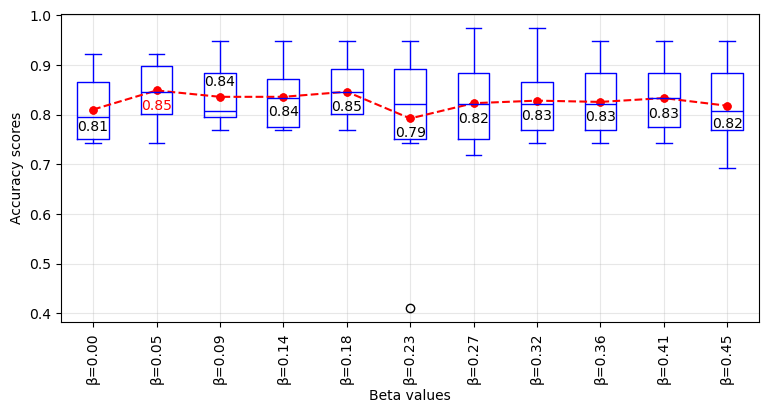

In [135]:
# Create a box plot with blue boxes

df = pd.DataFrame.from_dict(scores_dict)

box = df.boxplot(color=dict(boxes='blue', whiskers='blue', medians='blue', caps='blue'),figsize=(9,4),
                 grid=True
        )

# Calculate the mean values for each column
means = df.mean()

# Draw a line connecting the mean lines of the box plot
for i in range(len(means)):
    plt.plot([i + 1], [means[i]], marker='o', markersize=5, color='red')
    
plt.plot(range(1, len(df.columns) + 1), means.values, marker='o', markersize=5, color='red', linestyle='--')

plt.xticks(rotation=90)
plt.ylabel("Accuracy scores")
plt.xlabel("Beta values")

# # Annotate the box plot with mean values
# for i in range(len(means)):
#     plt.annotate(f'{means[i]:.2f}', (i + 1, means[i]), textcoords="offset points", xytext=(0,-55), ha='center')

xysize = [-15,-14,8,-14,-14,-13,-14,-14,-14,-14,-16]
# Annotate the box plot with mean values and color recent means red
for i in range(len(means)):
    color = 'red' if means[i] == max(means) else 'black'
#     if i < len(means)-1:
    plt.annotate(f'{means[i]:.2f}', (i + 1, means[i]), textcoords="offset points", xytext=(0,xysize[i]), ha='center', color=color)
#     else:
#         plt.annotate(f'{means[i]:.2f}', (i + 1, means[i]), textcoords="offset points", xytext=(0,-16), ha='center', color=color)
    

# Show the plot
plt.grid(alpha=0.3)
plt.show()

In [1]:
#results_df_.to_csv("Multiclass_LHSMRI_RHSPET_Sequential_GC_EMR_SLRA_MKSVM.csv")

In [247]:
from itertools import chain
results_df1 =  pd.concat([pd.DataFrame(results[0][each]) for each in ["train","test"]], axis=1)
col_labels1= [[f"Precision_{each}", f"Recall_{each}",f"F1_Score_{each}", f"Accuracy_{each}"] for each in ["Train","Test"]]
col_labels1 = list(chain(*col_labels1))
results_df1.columns = col_labels1

In [248]:
results_df1

,Precision_Train,Recall_Train,F1_Score_Train,Accuracy_Train,Precision_Test,Recall_Test,F1_Score_Test,Accuracy_Test
0,1.000000,1.000000,1.000000,1.000000,0.926094,0.923077,0.923685,0.923077
1,1.000000,1.000000,1.000000,1.000000,0.793909,0.794872,0.792181,0.794872
2,0.873675,0.870968,0.869490,0.870968,0.805556,0.794872,0.790749,0.794872
3,1.000000,1.000000,1.000000,1.000000,0.909158,0.897436,0.897680,0.897436
4,0.993698,0.993548,0.993561,0.993548,0.852888,0.846154,0.847281,0.846154
5,1.000000,1.000000,1.000000,1.000000,0.846154,0.846154,0.846154,0.846154
6,1.000000,1.000000,1.000000,1.000000,0.754986,0.743590,0.746003,0.743590
7,0.959290,0.954839,0.954730,0.954839,0.938462,0.923077,0.923372,0.923077
8,1.000000,1.000000,1.000000,1.000000,0.821884,0.820513,0.820445,0.820513
9,0.930289,0.922581,0.921986,0.922581,0.901662,0.897436,0.896154,0.897436


/var/folders/tk/6bnd7ryn65s_zkcb9yggf_zc0000gn/T/ipykernel_7009/1758381374.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot([i + 1], [means[i]], marker='o', markersize=5, color='red')


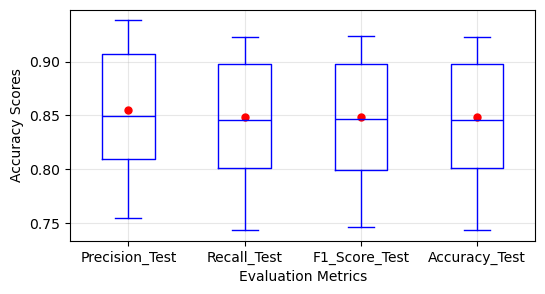

In [261]:
box1 = results_df_.boxplot(color=dict(boxes='blue', whiskers='blue', medians='blue', caps='blue'),figsize=(6,3),
                 grid=True
        )

# Calculate the mean values for each column
means = results_df_.mean()

# Draw a line connecting the mean lines of the box plot
for i in range(len(means)):
    plt.plot([i + 1], [means[i]], marker='o', markersize=5, color='red')
    
plt.grid(alpha=0.3)
plt.ylabel("Accuracy Scores")
plt.xlabel("Evaluation Metrics")
plt.show()

In [2]:
#results_df= np.load("regularization_result.npy", allow_pickle=True)
#results_df